In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.misc import *

In [2]:
import os,sys
from PIL import Image
import cv2
from tqdm import tqdm

In [3]:
train = pd.read_csv("C:/Users/dhiren/Downloads/indian-movie-face-database-imfdb/train.csv")
test = pd.read_csv("C:/Users/dhiren/Downloads/indian-movie-face-database-imfdb/test.csv")

In [4]:
train.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [5]:
train.describe()

,ID,Class
count,19906,19906
unique,19906,3
top,459.jpg,MIDDLE
freq,1,10804


In [6]:
train.Class.value_counts()

MIDDLE    10804
YOUNG      6706
OLD        2396
Name: Class, dtype: int64

In [7]:
TRAIN_PATH = 'C:/Users/dhiren/Downloads/indian-movie-face-database-imfdb/Train/Train/'
TEST_PATH = 'C:/Users/dhiren/Downloads/indian-movie-face-database-imfdb/Test/Test/'

In [8]:
# function to read images as arrays
def read_image(img_path, mode = 'color', resize = False, size = 32):
    '''
    Default mode is : color(BGR) --> color(RGB)
    Other modes allowed are : 'grayscale' and 'include_opacity'
    '''
    if mode == 'grayscale':
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    elif mode == 'include_opacity':
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    else:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if resize == True:
        img = cv2.resize(img, (size, size))
    
    return img

In [9]:
## Storing all images as list of arrays
train_data = []
test_data = []

for img in tqdm(train['ID'].values):
    train_data.append(read_image(TRAIN_PATH + '{}'.format(img), resize = True, size = 32))
    
for img in tqdm(test['ID'].values):
    test_data.append(read_image(TEST_PATH + '{}'.format(img), resize = True, size = 32))

100%|██████████████████████████████████████| 6636/6636 [02:00<00:00, 55.29it/s]


In [10]:
y_train = train['Class'].values

In [11]:
y_train

array(['MIDDLE', 'YOUNG', 'MIDDLE', ..., 'MIDDLE', 'MIDDLE', 'MIDDLE'],
      dtype=object)

In [12]:
## Checking dimensions and aspect ratio of original images (without resizing)
rows = [x.shape[0] for x in (train_data+test_data)]
cols = [x.shape[1] for x in (train_data+test_data)]
channels = [x.shape[2] for x in (train_data+test_data)]
aspect_ratio = [x.shape[0]/x.shape[1] for x in (train_data+test_data)]

In [13]:
## Checking range of the dimesnions and aspect ratio
print("Min. and Max. rows = {} and {} respectively \nMin. and Max. cols = {} and {} respectively \nMin. and Max. channels = {} and {} respectively \nMin. and Max. aspect ratio = {} and {} respectively \n"
      .format(min(rows), max(rows), min(cols), max(cols), min(channels), max(channels), min(aspect_ratio), max(aspect_ratio)))

Min. and Max. rows = 32 and 32 respectively 
Min. and Max. cols = 32 and 32 respectively 
Min. and Max. channels = 3 and 3 respectively 
Min. and Max. aspect ratio = 1.0 and 1.0 respectively 



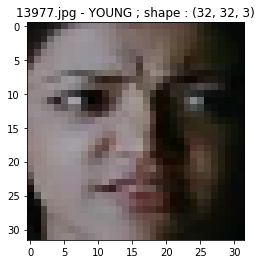

In [14]:
## Displaying random images without resizing
i = np.random.choice(np.arange(len(train_data)))

plt.title('{} - {} ; shape : {}'.format(train['ID'].values[i], y_train[i], train_data[i].shape))
plt.imshow(train_data[i])

In [15]:
## Scaling the images
X_train = np.array(train_data, np.float32) / 255.
X_test = np.array(test_data, np.float32) / 255.

In [16]:
# Encoding image labels into target variables (categorical)
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

#ohe = OneHotEncoder(categorical_features = [0])
#y_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()
y_train = pd.get_dummies(y_train).values

In [17]:
y_train.shape

(19906, 3)

In [18]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import PReLU, LeakyReLU, ELU
from keras.optimizers import Adam
from keras.constraints import maxnorm

from keras import backend as K
K.image_data_format()

from keras.preprocessing import image

In [19]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
import keras 

In [20]:
model = Sequential([
        BatchNormalization(input_shape = (32,32,3)),
        Convolution2D(28,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        Convolution2D(32,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        Convolution2D(128,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.2),
        Dense(384, activation='linear'),
        LeakyReLU(alpha = 0.3),
        Dropout(0.2),
        Dense(3, activation='softmax')
        ])
model.compile(optimizer = Adam(learning_rate=0.001) , loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
## Saving initial un-trained weights for future use
model.save_weights('initial_weights.h5')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 28)        784       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30, 30, 28)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 28)        112       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        8096      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        1

In [23]:
## Building a custom function for learning rate decay/annealing
def lr_decay(start, stop, div_step_1, div_step_2 = 2) :
    k = 1
    while start >= stop:
        yield start
        if k==1 :
            start/= div_step_1
        else : start/= div_step_2
        k = k * -1

In [24]:
from sklearn.model_selection import train_test_split
X_trn, X_valid, y_trn, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

In [25]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, shear_range=0.25,
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip = True)
batches = gen.flow(X_trn, y_trn, batch_size = 64)
val_batches = gen.flow(X_valid, y_valid, batch_size = 64)

In [26]:
model.fit_generator(batches, (X_trn.shape[0]//batches.batch_size), epochs=10,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]//val_batches.batch_size))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
248/248 [==============================] - 193s 780ms/step - loss: 1.3621 - accuracy: 0.5615 - val_loss: 1.0394 - val_accuracy: 0.5048
Epoch 2/10
248/248 [==============================] - 167s 673ms/step - loss: 0.8528 - accuracy: 0.6279 - val_loss: 0.8607 - val_accuracy: 0.6134
Epoch 3/10
248/248 [==============================] - 161s 649ms/step - loss: 0.7672 - accuracy: 0.6648 - val_loss: 0.7498 - val_accuracy: 0.6815
Epoch 4/10
248/248 [==============================] - 161s 651ms/step - loss: 0.7316 - accuracy: 0.6838 - val_loss: 0.7188 - val_accuracy: 0.6847
Epoch 5/10
248/248 [==============================] - 159s 643ms/step - loss: 0.7163 - accuracy: 0.6901 - val_loss: 0.7390 - val_accuracy: 0.6784
Epoch 6/10
248/248 [==============================] - 162s 654ms/step - loss: 0.6971 - accuracy: 0.7046 - val_loss: 0.7004 - val_accuracy: 0.6988
Epoch 7/10
248/248 [============================

In [27]:
## Saving weights as a form of model checkpointing
model.save_weights('leakyReLU_age-detection_weights.h5')

In [28]:
## Building the autoencoder pipeline

input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (8, 4, 4, 3) i.e. 384-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding = 'same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [29]:
## Composing the autoencoder model and compiling it
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [30]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 8)           0     

In [31]:
from keras.callbacks import TensorBoard

In [32]:
## Fitting the autoencoder model
autoencoder.fit(X_train, X_train,
                epochs= 10,
                batch_size= 64,
                shuffle= True,
                validation_data= (X_test, X_test))
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/10
312/312 [==============================] - 98s 315ms/step - loss: 0.6954 - val_loss: 0.6950
Epoch 2/10
312/312 [==============================] - 98s 313ms/step - loss: 0.6947 - val_loss: 0.6944
Epoch 3/10
312/312 [==============================] - 99s 316ms/step - loss: 0.6940 - val_loss: 0.6937
Epoch 4/10
312/312 [==============================] - 97s 310ms/step - loss: 0.6934 - val_loss: 0.6931
Epoch 5/10
312/312 [==============================] - 97s 311ms/step - loss: 0.6928 - val_loss: 0.6925
Epoch 6/10
312/312 [==============================] - 96s 309ms/step - loss: 0.6922 - val_loss: 0.6919
Epoch 7/10
312/312 [==============================] - 97s 311ms/step - loss: 0.6914 - val_loss: 0.6910
Epoch 8/10
312/312 [==============================] - 98s 314ms/step - loss: 0.6905 - val_loss: 0.6900
Epoch 9/10
312/312 [==============================] - 100s 321ms/step - loss: 0.6894 - val_loss: 0.6889
Epoch 10/10
312/312 [==============================] - 98s 314ms/step - 

In [33]:
autoencoder.fit(X_train, X_train,
                epochs= 10,
                batch_size= 64,
                shuffle= True,
                validation_data= (X_test, X_test))

Epoch 1/10
312/312 [==============================] - 100s 320ms/step - loss: 0.6872 - val_loss: 0.6867
Epoch 2/10
312/312 [==============================] - 110s 351ms/step - loss: 0.6861 - val_loss: 0.6856
Epoch 3/10
312/312 [==============================] - 90s 288ms/step - loss: 0.6849 - val_loss: 0.6843
Epoch 4/10
312/312 [==============================] - 91s 290ms/step - loss: 0.6836 - val_loss: 0.6830
Epoch 5/10
312/312 [==============================] - 90s 289ms/step - loss: 0.6823 - val_loss: 0.6817
Epoch 6/10
312/312 [==============================] - 90s 289ms/step - loss: 0.6809 - val_loss: 0.6803
Epoch 7/10
312/312 [==============================] - 90s 290ms/step - loss: 0.6795 - val_loss: 0.6788
Epoch 8/10
312/312 [==============================] - 91s 292ms/step - loss: 0.6779 - val_loss: 0.6772
Epoch 9/10
312/312 [==============================] - 90s 289ms/step - loss: 0.6763 - val_loss: 0.6756
Epoch 10/10
312/312 [==============================] - 91s 291ms/step -

In [34]:
X_test.shape

(6636, 32, 32, 3)

In [35]:
decoded_imgs = autoencoder.predict(X_test)

In [36]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis= 1)

In [37]:
# Converting predicted category numbers to predicted labels
unique_labels = np.unique(train['Class'].tolist())
pred_labels = unique_labels[predictions]

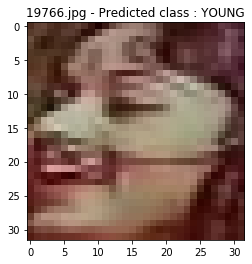

In [38]:
## Let's see what our classifier predicts on test images
# Random predictions
i = np.random.choice(np.arange(len(test_data)))
plt.title('{} - Predicted class : {}'.format(test['ID'].values[i], pred_labels[i]))
plt.imshow(test_data[i])

In [ ]:
# Prepare submission file
subm = pd.DataFrame({'Class':pred_labels, 'ID':test.ID})
subm.to_csv('/home/akshay/Desktop/ageprediction.csv', index=False)

In [39]:
from tkinter import * 
from PIL import ImageTk, Image  
from tkinter import filedialog
from tkinter.ttk import *
from tkinter.scrolledtext import ScrolledText

root = Tk()
root.title('Age Prediction')
root.geometry('1360x780')

head = Label(root, text='Welcome to Age Prediction', font='comicsansms 19 bold', background='#66ffc2', foreground='black')
head.pack(pady=20)

def open_img(): 
    # Select the Imagename  from a folder  
    x = openfilename() 
  
    # opens the image 
    img = Image.open(x) 
      
    # resize the image and apply a high-quality down sampling filter 
    img_resize = img.resize((250, 250), Image.ANTIALIAS) 
  
    # PhotoImage class is used to add image to widgets, icons etc 
    img_plot = ImageTk.PhotoImage(img_resize) 
   
    # create a label 
    panel = Label(root, image = img_plot) 
      
    # set the image as img  
    panel.image = img_plot
    panel.pack(pady=10)
    
    # give image for prediction
    mylist = []
    mylist.append(read_image(x, resize = True, size = 32))
    testing = np.array(mylist, np.float32) / 255.
    predictions = model.predict(testing)
    predictions = np.argmax(predictions, axis= 1)
    unique_labels = np.unique(train['Class'].tolist())
    pred_labels = unique_labels[predictions]
    
    show = f"By using Age Prediction Model, The person in above image is {pred_labels[0]} aged person"
    Label(root, text=show, font = 'comicsansms 12', background='#66ffc2', foreground='black').pack(pady=10)

def openfilename(): 
  
    # open file dialog box to select image 
    # The dialogue box has a title "Open" 
    filename = filedialog.askopenfilename(title ='open') 
    return filename 

Label(root, text = 'Enter the following button to select an image', font = 'comicsansms 12', background='#66ffc2', foreground='black').pack(pady=10)
style = Style()
style.configure('W.TButton', font='comicsansms 11', background='#66ffc2')
btn = Button(root, text ='open image', command = open_img, style='W.TButton').pack()

root['bg'] = '#66ffc2'
mainloop()